# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2024

Côté, Gabriel, 2082508

Tourigny, François, 2079718

Note finale:

<u>**Date limite de remise :**</u>  4 décembre 23h59 pour les deux groupes

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Le problème qu'on vous demande de résoudre cette fois-ci est un peu plus difficile. Vous êtes responsable de la séparation des voteurs d'un pays en circonscriptions. Un des deux candidats principaux, M. T, vient vous voir et vous demande de lui garantir une victoire (pour un montant non négligeable d'argent). Évidemment, vous refusez, mais le problème est intéressant et vous décidez d'essayez de le résoudre. Si ça vous intéresse, ce problème est ce qu'on appelle du *gerrymandering*.

Vous aurez comme entrée à votre problème une carte du pays (représentée par une matrice carrée $n \times n$) qui contient à chaque position le nombre de voteurs pour candidat X (un chiffre entre 0 et 1000). Votre objectif est de créer $n$ circonscriptions de sorte à ce que candidat X gagne l'élection. Quelques spécifications importantes:

- La variable $n$ représente un côté de la matrice. Il y a donc, $n^2$ villes.
- Chaque position de la matrice représente une ville
- Chaque circonscription doit contenir **$n$ villes**. Une solution reste valide si une circonscription ne contient pas exactement $n$ villes, mais il y a une **pénalité** qui y est associée.
- Les villes d'une circonscription doivent être proche les unes des autres. On aimerait garder cette **distance à, au plus, $n/2$**. Encore une fois, on permet de briser cette contrainte, mais il y aura une pénalité qui y est associée. (**Distance manhattan**)
- Les villes d'une circonscription ne doivent **pas être nécessairement voisines** tant qu'on respecte la distance maximale. Voir l'exemple plus bas.
- Le candidat remporte une circonscription si le nombre de voteurs dans cette circonscription est supérieur à $500n$.
- Le candidat cherche à remporter le plus de circonscriptions qu'il peut.

![alt text](distance_example.png)


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une matrice carrée de taille $n$ contenant des nombres entre $1$ et $1000$. Vous pouvez utilisez des exemplaires aléatoires pour tester votre code. La compétition sera faite sur les mêmes exemplaires de tailles différentes pour toutes les équipes d'un même groupe.

In [83]:
import random
from collections.abc import Iterable

def generate_city() -> int:
    return round(min(1000,max(0,random.normalvariate(450,200))))

class Problem():
    def __init__(self, size: int, num_samples: int = 5) -> None:
        self.size = size
        self.num_samples = num_samples

    def generate_sample(self) -> list[list[int]]:
        """Returns a matrix containing values between 0 and 1000. Each value is the number of voters in a given city"""
        return [[generate_city() for _ in range(self.size)] for _ in range(self.size)]

    def generate_dataset(self) -> Iterable[list[list[int]]]:
        """Returns an iterator over as many samples as are described"""
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [84]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import ceil
import math
from scipy.stats import linregress
import numpy as np
from tqdm import trange

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def score_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Returns the score of the current solution. The score function is a penalty that must be minimized."""
    return votes_score(original, solution) + size_score(solution) + distance_score(solution)

def votes_score(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to lost districts. 
    It is 5 times the square of the number of lost districts."""
    lost_districts = 0
    for district in solution:
        sum = 0
        for city in district:
            sum += original[city[0]][city[1]]
        if sum <= 500*len(district):
            lost_districts += 1
    return 5 * lost_districts**2

def size_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to districts having the wrong size.
    It is the square of the difference between the wanted number of cities and the 
    current number of cities in a given district."""
    n = len(solution)
    size_penality = 0
    for district in solution:
        size_penality += (len(district)-n)**2
    return size_penality

def distance_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to the distance between cities in a district.
    It is the mean square distance between each city and every other city in its district."""
    distance_score = 0
    n = len(solution)
    for district in solution:
        for i,city in enumerate(district):
            for j in range(i+1, len(district)):
                distance_score += (max(0, distance_manhattan(city, district[j])-ceil(n/2)))**2
    return distance_score/len(solution)

def distance_manhattan(city_a: tuple[int,int], city_b: tuple[int,int]) -> int:
    return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

def is_valid_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> bool:
    """Validates solution"""
    n = len(original)

    if len(solution) != n:
        print(f"The solution does not contain {n} districts.")
        return False

    for district in solution:
        if len(district) < 1:
            print("The solution contains empty districts.")
            return False
        for city in district:
            if len(city)!=2:
                print("Solution must contain 2 coordinates per city.")
                return False
        for coord in city:
            if coord < 0 or coord >=n:
                print(f"City coordinates must below {n} and positive.")
                return False

    coord_set = set()
    for district in solution:
        for city in district:
            coord_set.add(city)
    if len(coord_set) != n*n:
        print(f"Solution contained {len(coord_set)} different cities while there should be {n*n} cities in the solution.")
        return False

    # Solution is valid
    return True

def make_problems(sizes: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    return [Problem(size,num_samples) for size in sizes]

def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
    """Returns a tuple containing the time as well as the score of the solution, in that order.
    
    Parameters:
        time_scale: Controls the level of precision of the time measurements.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return (round(end - start), score_solution(sample, solution))

def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns a Measure 
    instance representing the result as well as the problem.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(result[0] for result in results) / prob.num_samples
    mean_score = sum(result[1] for result in results) / prob.num_samples
    return Measure(prob.size, mean_time, mean_score)

def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken for each problem in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time and the score.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.mean, measure.mean_score))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

# Algorithme

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

In [85]:
class County():
    def __init__(self, row: int, col: int, pos: int, voters: int) -> None:
        self.row = row
        self.col = col
        self.pos = pos
        self.voters = voters
        self.neighbors = []
        self.group = -1

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def get_neighbours(self):
        return self.neighbors
    
    def set_group(self, group: int):
        self.group = group
    
    def get_group(self):
        return self.group
    
    def is_in_group(self):
        return self.group != -1


In [86]:
def get_neighbours_idx(idx, n):
    neighbours = []
    if idx - n > 0:
        neighbours.append(idx-n)
    if idx + n < n**2:
        neighbours.append(idx+n)
    if idx // n == (idx-1) // n:
        neighbours.append(idx-1)
    if idx // n == (idx+1) // n:
        neighbours.append(idx+1)
    return neighbours

def set_counties(sample) -> list[County]:
    n = len(sample)
    counties = [County(i, j, i*n+j, county) for i, line in enumerate(sample) for j, county in enumerate(line)]
    for county in counties:
        for neighbor_idx in get_neighbours_idx(county.pos, n):
            county.add_neighbor(counties[neighbor_idx])
    return counties


In [87]:
def distance(county_row, county_col, center_row, center_col, n):
    return (abs(center_row - county_row) + abs(center_col - county_col))
    
def max_to_target(counties: list[County], target: int, n: int):
    solution = []
    counties_available = counties
    groups = []
    groups_center = []
    center_row = 0
    center_col = 0
    for group_id in trange(n):
        new_group = []
        number_items = 0
        center_row = 0
        center_col = 0
        group_neighbors = []
        while len(new_group) < n:
            selection = None
            if len(group_neighbors) == 0:
                selection = max(counties_available, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
            elif sum(county.voters for county in new_group) < target:
                selection = max(group_neighbors, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
                #selection = random.choice(group_neighbors)
            else:
                selection = min(group_neighbors, key=lambda county: county.voters/n + distance(county.row, county.col, center_row, center_col, n)**2/n)

            new_group.append(selection)
            center_row = (center_row * number_items + selection.row) / (number_items + 1)
            center_col = (center_col * number_items + selection.col) / (number_items + 1)
            number_items += 1
            selection.set_group(group_id)
            
            group_neighbors.extend([neighbor for neighbor in selection.neighbors if not neighbor.is_in_group() and not neighbor in group_neighbors])
            counties_available.remove(selection)
            if selection in group_neighbors:
                group_neighbors.remove(selection)
            
        groups.append(new_group)
        groups_center.append((center_row, center_col))
        solution.append([(county.row, county.col) for county in new_group])
    return solution, groups



In [88]:

def main(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    print('improvement')
    while(True):
        updated = amelioration_locale(groups, target, n, sample, sol)
        sol = updated

        if (time.time() - start_time) > max_time - time_to_iter:
            return sol
        if(first_iter):
            first_iter = False
            time_to_iter = (time.time() - iter_time)

    #print(" ---------------- AFTER UPDATE -----------------")
    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('total score: ', score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol


def amelioration_locale(divisions, target, n, sample, sol):
    #init_score = score_solution(sample, sol)
    div_votes = [sum(county.voters for county in div) for div in divisions]
    groups_center = [(sum(county.row for county in div)/n, sum(county.col for county in div)/n) for div in divisions]

    #selected_div_idx = div_votes.index(max(div for div in div_votes if div < target))
    #selected_div_idx = divisions.index(random.choice([div for div in divisions if sum(county.voters for county in div) < target]))
    selected_div_idx = divisions.index(random.choice(divisions))
    #selected_div_idx = div_votes.index(min(div_votes))

    selected_div = divisions[selected_div_idx]
    center_swap_group_row = groups_center[selected_div_idx][0]
    center_swap_group_col = groups_center[selected_div_idx][1]

    modified_selected_div = [county.voters + distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n) for county in selected_div]
    county_to_swap_idx = modified_selected_div.index(min(modified_selected_div))
    county_to_swap = divisions[selected_div_idx][county_to_swap_idx]
    #print('county to swap: ', county_to_swap.pos)
    differential_needed = target - county_to_swap.voters
    distance_div_swap = distance(center_swap_group_row, center_swap_group_col, county_to_swap.row, county_to_swap.col, n)

    swap_scores = {}
    for div_idx in range(len(divisions)):
        if div_idx == selected_div_idx:
            continue

        votes_to_spare = div_votes[div_idx] - target
        if votes_to_spare <= 0:
            votes_to_spare = target
        
        div_center_row = groups_center[div_idx][0]
        div_center_col = groups_center[div_idx][1]
        distance_div_swap_new_group = distance(div_center_row, div_center_col, county_to_swap.row, county_to_swap.col, n)

        for county_idx, county in enumerate(divisions[div_idx]):
            if county.voters - county_to_swap.voters > votes_to_spare:
                continue
            dist_county_curr_group = distance(div_center_row, div_center_col, county.row, county.col, n)
            dist_county_swap_group = distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n)
            score_voters =  (county.voters/n - county_to_swap.voters/n) + (0 if county.voters - county_to_swap.voters < differential_needed else target)
            score_distance = (dist_county_curr_group + distance_div_swap) - (dist_county_swap_group + distance_div_swap_new_group)
            swap_scores[county.pos] = score_voters + n * score_distance

    #print(swap_scores)
    if len(swap_scores) == 0:
        return sol
    switch_county_pos = max(swap_scores, key=swap_scores.get)
    if swap_scores[switch_county_pos] < 0:
        return sol
    #print(switch_county_pos)
    switch_county_row = switch_county_pos // n
    switch_county_col = switch_county_pos % n

    div_switch_idx = -1
    pos_pair_switch = (switch_county_row, switch_county_col)
    for div_idx in range(len(divisions)):
        if pos_pair_switch in sol[div_idx]:
            div_switch_idx = div_idx
    
    #update solution
    sol[div_switch_idx].remove(pos_pair_switch)
    sol[div_switch_idx].append((county_to_swap.row, county_to_swap.col))

    sol[selected_div_idx].append(pos_pair_switch)
    sol[selected_div_idx].remove((county_to_swap.row, county_to_swap.col))

    #update divisions
    divisions[selected_div_idx].remove(county_to_swap)
    pos_arr = [div.pos for div in divisions[div_switch_idx]]

    idx_select = pos_arr.index(switch_county_pos)
    switch = divisions[div_switch_idx][idx_select]
    divisions[selected_div_idx].append(switch)

    divisions[div_switch_idx].append(county_to_swap)
    divisions[div_switch_idx].remove(switch)

    #print('new score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol
    




In [89]:
resultats = measure_range(main, make_problems([100], 1) )

display_data_as_table(resultats)

initial solution


100%|██████████| 100/100 [00:02<00:00, 41.50it/s]


--- 2.444875478744507 seconds for solution baseline ---
improvement


KeyboardInterrupt: 

In [ ]:
def drawmap_of_discrits(n, discrits: list[list[tuple[int,int]]]):
    colors = [[0 for _ in range(n)] for _ in range(n)]
    for i,district in enumerate(discrits):
        for city in district:
            colors[city[0]][city[1]] = i+1

    plt.imshow(colors, cmap='tab20')
    plt.show()


# Analyse asymptotique

Notre algorithme se sépare en 3 grande sections. La première d'entre elle est la création des objets County avoir leur voisinage. La seconde section est la génération d'une séparation initiale et la dernière partie est une amélioration locale.

# Création des County
Commençons par la création des County. La création se sépare en 2 phases, la première est de créer chaque County qui se fait en temps constant pour les n² éléments donc ceci nous donne theta(n²). La seconde étape de création est de passer par chacun des County créés et placer leur voisins qui sont au nombre maximal de 4 donc nous avons une complexité de theta(4*n²) qui est dans le même ordre de grandeur que theta(n²). Bref, la création des objets County se fait en theta(n² + n²) ce qui veut dire une complexité de theta(n²).

# Séparation initiale
La deuxième portion de notre algorithme est un algorithme glouton qui fait une répartion des County en n groupes. Dans chacun des n groupes, on fait n fois la recherche d'un prochain élément. Dans cette recherche de prochain élément, nous avons 2 choix qui sont de faire une rechreche parmis les voisins s'il y en a et sinon parmis tout les County qui ne sont pas déjà choisis dans un groupe. Dans le pire des cas, nous avons n² choix pour notre recherche de la valeur maximale. Ce qui nous donne une complexité de theta(n\*n\*n²) ceci équivaut à une complexité de theta(n⁴).

# Amélioration locale
La dernière partie est une amélioration locale. L'amélioration se fait en plusieurs sections successives. La première de ces sections de l'amélioration locale est de calculer le centre du groupe nous avons n appels de la distance pour chacun des n groupes ce qui fait au total n² appels de la distance qui est un calcul en temps constant. Cette première partie de l'amélioration locale est donc en theta(n²\*1) donc theta(n²).
La seconde partie de l'amélioration locale est la sélection d'un County à échanger qui est en theta(n) pour le choix du groupe dans lequel prendre le County à échanger puis de theta(n) pour choisir le County parmis le groupe choisi. Ceci nous theta(n+n) donc theta(n) pour la sélection du County à échanger. Nous devons ensuite sélectionner le County avec lequel le premier chois sera échangé. Pour tous les County qui ne sont pas dans le groupe initial, nous générons un score de préférence pour faire l'échange avec le County choisi initialement. Ce calcul de score est en temps constant pour les au maximum n² County possibles pour faire un échange. Bref, le choix du second County pour l'échange se fait en theta(n²\*1) ce qui donne theta(n²).
Finalement, pour l'amélioration locale, nous avons l'échange des deux éléments qui se fait en temps constant theta(1).
Notre section d'amélioration locale se fait donc avec la complexité suivante theta(n²+n²+1) ce qui nous donne theta(n²)
La section d'amélioration locale est exécutée tant que du temps est disponible (avec une marge de sureté), mais ultimement le nombre d'exécutions peut être comme indépendant de n.

# Algorithme complet
Pour notre algorithme complet, nous pouvons additionner la complexité théorique de nos sections, car elle sont exécutées l'une à la suite de l'autre.
Nous avons donc theta(n²+n⁴+n²) ce qui nous donne une complexitée finale de theta(n⁴)

# Analyse hybride


PAS faire le test de constante (pour deux variable et on a pas)
Faire le test de puissance (faire en log log comme échelle) On devrait voir la valeur 4x
On peut utiliser un test de rapport pour confirmer le test de puissance
Faire le test de rapport en dernier si tout fonctionne


Expliquer l'utilisation de chacun des graphiques, expliquer en quoi le graphique justifie la complexité et pourquoi ne pas utiliser certain graphiques.

Effectuer une analyse hybride de votre algorithme.

In [115]:
problems = make_problems([x for x in range(11, 61)], 10)

In [116]:
# On réécris certaines fonctions pour pouvoir les évaluer individuellement sans contrainte de temps maximum

def main_greedy(sample):
    start_time = time.time()
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))
    return sol
    

### Génération de moyennes

Ici on génère les moyennes de temps et de score pour chaque grandeur de n. On calcule à partir de n = 11 pour éviter le plus possible les problèmes de temps moyen inconsistant quand notre n est très petit. Pour plus de stabilité, nous faisons 10 runs par grandeur de n, pour au total 50 valeurs de n.

In [117]:
resultats_greedy = measure_range(main_greedy, problems)

display_data_as_table(resultats_greedy)


initial solution


100%|██████████| 11/11 [00:00<00:00, 7193.22it/s]


--- 0.00496220588684082 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5507.62it/s]


--- 0.005002260208129883 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 7310.62it/s]


--- 0.0040166378021240234 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10891.72it/s]


--- 0.004473686218261719 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10902.02it/s]


--- 0.004520416259765625 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 11013.93it/s]


--- 0.004004001617431641 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 6242.37it/s]


--- 0.005632162094116211 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5111.60it/s]


--- 0.004151105880737305 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5303.75it/s]


--- 0.0060808658599853516 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 11021.82it/s]


--- 0.004507303237915039 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5996.86it/s]


--- 0.004002571105957031 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5986.16it/s]


--- 0.00423884391784668 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 6399.45it/s]


--- 0.003876209259033203 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5995.43it/s]


--- 0.005096912384033203 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5591.78it/s]


--- 0.0076558589935302734 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 12012.33it/s]


--- 0.004998445510864258 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5146.39it/s]


--- 0.004484415054321289 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5999.72it/s]


--- 0.00551605224609375 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 12009.46it/s]


--- 0.006005764007568359 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4431.77it/s]


--- 0.005484342575073242 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6506.68it/s]


--- 0.005000591278076172 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4331.93it/s]


--- 0.005002021789550781 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 5711.32it/s]


--- 0.006781816482543945 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4342.28it/s]


--- 0.006651878356933594 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4323.00it/s]


--- 0.005669832229614258 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6460.42it/s]


--- 0.0050144195556640625 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6499.70it/s]


--- 0.006005525588989258 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4833.43it/s]


--- 0.005826473236083984 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6503.57it/s]


--- 0.004999876022338867 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 3796.81it/s]


--- 0.007420778274536133 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2795.40it/s]


--- 0.009676933288574219 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2801.41it/s]


--- 0.011016607284545898 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5580.18it/s]


--- 0.007673501968383789 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2734.23it/s]


--- 0.009125232696533203 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4665.52it/s]


--- 0.006302356719970703 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4505.51it/s]


--- 0.006106376647949219 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 7008.86it/s]


--- 0.00700068473815918 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4665.52it/s]


--- 0.0050008296966552734 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4671.09it/s]


--- 0.0050008296966552734 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6956.55it/s]


--- 0.008014440536499023 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4271.48it/s]


--- 0.005673408508300781 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 5000.36it/s]


--- 0.006575584411621094 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4988.07it/s]


--- 0.00935816764831543 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3738.46it/s]


--- 0.0070040225982666016 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4984.52it/s]


--- 0.0061511993408203125 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4984.52it/s]


--- 0.006514787673950195 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4998.77it/s]


--- 0.006003618240356445 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3983.19it/s]


--- 0.007763862609863281 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 5439.14it/s]


--- 0.008467435836791992 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4862.02it/s]


--- 0.007831573486328125 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5071.71it/s]


--- 0.006683349609375 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3987.93it/s]


--- 0.008013486862182617 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3980.36it/s]


--- 0.007174015045166016 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3773.55it/s]

--- 0.0062410831451416016 seconds for solution baseline ---
initial solution



100%|██████████| 16/16 [00:00<00:00, 5332.87it/s]


--- 0.008008956909179688 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4311.25it/s]


--- 0.007716178894042969 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5694.91it/s]


--- 0.0074841976165771484 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3845.34it/s]


--- 0.007168292999267578 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3769.10it/s]


--- 0.008246421813964844 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4392.52it/s]


--- 0.12937378883361816 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3266.59it/s]


--- 0.00871419906616211 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3294.67it/s]


--- 0.007668256759643555 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4250.81it/s]


--- 0.009429216384887695 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3764.49it/s]


--- 0.008517265319824219 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2160.11it/s]


--- 0.011879920959472656 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3626.81it/s]


--- 0.010410547256469727 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3739.22it/s]


--- 0.009852409362792969 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4102.60it/s]


--- 0.008759498596191406 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3498.86it/s]


--- 0.00885772705078125 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4080.53it/s]


--- 0.007164955139160156 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3502.39it/s]


--- 0.009142160415649414 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3501.58it/s]


--- 0.011713266372680664 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2916.99it/s]


--- 0.010180950164794922 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3445.64it/s]

--- 0.011559247970581055 seconds for solution baseline ---
initial solution



100%|██████████| 18/18 [00:00<00:00, 3989.09it/s]


--- 0.008786439895629883 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3396.04it/s]


--- 0.00946497917175293 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4503.82it/s]


--- 0.008020639419555664 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3515.27it/s]


--- 0.010198593139648438 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3509.23it/s]


--- 0.008138418197631836 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3477.54it/s]


--- 0.009201288223266602 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3267.66it/s]


--- 0.010171651840209961 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2651.97it/s]


--- 0.011548519134521484 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2252.13it/s]


--- 0.013434648513793945 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2572.53it/s]


--- 0.011530399322509766 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3094.23it/s]


--- 0.012206554412841797 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2639.85it/s]


--- 0.014203071594238281 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3159.11it/s]


--- 0.010181665420532227 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3079.04it/s]


--- 0.011185407638549805 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3103.62it/s]


--- 0.011021137237548828 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3159.74it/s]


--- 0.010155916213989258 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2800.31it/s]


--- 0.011142969131469727 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2858.23it/s]


--- 0.010997295379638672 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2429.86it/s]


--- 0.013307332992553711 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2764.78it/s]


--- 0.010386943817138672 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2805.65it/s]


--- 0.012136459350585938 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1809.53it/s]


--- 0.016671419143676758 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1542.28it/s]


--- 0.02366328239440918 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2151.04it/s]


--- 0.013680696487426758 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2479.71it/s]


--- 0.012577056884765625 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2857.45it/s]


--- 0.011516571044921875 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2463.51it/s]


--- 0.012961864471435547 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2667.41it/s]


--- 0.0159912109375 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2900.05it/s]


--- 0.013241052627563477 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2470.63it/s]


--- 0.012022733688354492 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2793.36it/s]


--- 0.012835264205932617 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2920.73it/s]


--- 0.012699365615844727 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2703.10it/s]


--- 0.013353586196899414 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2744.62it/s]


--- 0.012742280960083008 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2895.86it/s]


--- 0.012775659561157227 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2503.28it/s]


--- 0.013557195663452148 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2083.80it/s]


--- 0.015407085418701172 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1747.73it/s]


--- 0.01680731773376465 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2691.17it/s]


--- 0.01347970962524414 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1751.71it/s]

--- 0.02030777931213379 seconds for solution baseline ---
initial solution



100%|██████████| 22/22 [00:00<00:00, 2404.99it/s]


--- 0.014170408248901367 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2417.09it/s]


--- 0.01725006103515625 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1983.04it/s]


--- 0.015851974487304688 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2441.78it/s]


--- 0.015000104904174805 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2242.51it/s]


--- 0.014506101608276367 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2264.41it/s]


--- 0.014329910278320312 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1951.87it/s]


--- 0.01496267318725586 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2370.59it/s]


--- 0.015593528747558594 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2267.72it/s]


--- 0.015324831008911133 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1860.50it/s]


--- 0.01753544807434082 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2041.07it/s]


--- 0.016327381134033203 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2087.08it/s]


--- 0.016321182250976562 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2147.81it/s]

--- 0.01633310317993164 seconds for solution baseline ---
initial solution



100%|██████████| 23/23 [00:00<00:00, 1849.16it/s]


--- 0.017455101013183594 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1859.82it/s]


--- 0.017946958541870117 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2149.39it/s]


--- 0.017747163772583008 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2141.36it/s]


--- 0.01661086082458496 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1971.01it/s]


--- 0.021372556686401367 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2050.84it/s]


--- 0.017263412475585938 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2021.88it/s]


--- 0.017195940017700195 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1744.63it/s]


--- 0.020545482635498047 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2096.37it/s]


--- 0.016460418701171875 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1696.01it/s]


--- 0.01820850372314453 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1807.37it/s]


--- 0.018656253814697266 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1620.96it/s]

--- 0.019899606704711914 seconds for solution baseline ---
initial solution



100%|██████████| 24/24 [00:00<00:00, 2230.17it/s]


--- 0.021091938018798828 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1685.38it/s]


--- 0.018599748611450195 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1859.87it/s]


--- 0.01894235610961914 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1803.54it/s]


--- 0.01786208152770996 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1872.79it/s]


--- 0.018806934356689453 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1963.88it/s]


--- 0.0172426700592041 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1750.49it/s]


--- 0.021555185317993164 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1842.45it/s]


--- 0.018395423889160156 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1188.86it/s]


--- 0.02603888511657715 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1304.96it/s]


--- 0.02539992332458496 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1895.82it/s]


--- 0.018196821212768555 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1681.55it/s]


--- 0.021573305130004883 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1414.79it/s]


--- 0.02565455436706543 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1657.55it/s]


--- 0.023006677627563477 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1487.04it/s]


--- 0.022953033447265625 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1743.49it/s]


--- 0.02085399627685547 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1845.27it/s]


--- 0.020989656448364258 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1651.73it/s]


--- 0.020623207092285156 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1634.52it/s]


--- 0.020411252975463867 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1504.60it/s]


--- 0.027282238006591797 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1327.47it/s]


--- 0.02527642250061035 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1475.25it/s]


--- 0.025742053985595703 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1285.41it/s]


--- 0.026597976684570312 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1707.19it/s]


--- 0.022059202194213867 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1359.40it/s]


--- 0.025131940841674805 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1484.34it/s]


--- 0.02623271942138672 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1434.44it/s]


--- 0.024328231811523438 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1371.42it/s]


--- 0.02569413185119629 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1502.88it/s]


--- 0.02338433265686035 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1509.61it/s]


--- 0.023331403732299805 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1456.62it/s]


--- 0.024953842163085938 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1345.33it/s]


--- 0.02765369415283203 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1285.39it/s]


--- 0.025795698165893555 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1344.27it/s]


--- 0.028789758682250977 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1366.38it/s]


--- 0.026494264602661133 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1214.67it/s]

--- 0.02912163734436035 seconds for solution baseline ---


initial solution


100%|██████████| 28/28 [00:00<00:00, 1248.77it/s]


--- 0.030753135681152344 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1372.43it/s]


--- 0.02677607536315918 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1367.93it/s]


--- 0.027626752853393555 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 984.33it/s]


--- 0.034583330154418945 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 942.43it/s]


--- 0.03571009635925293 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 712.03it/s]

--- 0.05032157897949219 seconds for solution baseline ---


initial solution


100%|██████████| 29/29 [00:00<00:00, 1178.04it/s]


--- 0.03483223915100098 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1218.15it/s]


--- 0.030983924865722656 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1104.06it/s]


--- 0.03758859634399414 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1286.75it/s]


--- 0.028543710708618164 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1015.63it/s]


--- 0.03456306457519531 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1421.45it/s]


--- 0.02856731414794922 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1304.13it/s]


--- 0.02922677993774414 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1253.92it/s]


--- 0.029616117477416992 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1310.75it/s]


--- 0.030215740203857422 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1217.34it/s]


--- 0.03078460693359375 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1159.75it/s]


--- 0.03287672996520996 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1062.80it/s]


--- 0.03444695472717285 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1064.70it/s]

--- 0.036910057067871094 seconds for solution baseline ---
initial solution



100%|██████████| 30/30 [00:00<00:00, 1228.14it/s]


--- 0.03173470497131348 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1200.61it/s]


--- 0.033295392990112305 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1038.85it/s]


--- 0.03441500663757324 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1181.43it/s]


--- 0.03204536437988281 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1222.62it/s]


--- 0.03100109100341797 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1268.60it/s]


--- 0.028523683547973633 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 981.60it/s]


--- 0.04281735420227051 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1111.42it/s]


--- 0.03589224815368652 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1067.48it/s]


--- 0.035056352615356445 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1071.71it/s]


--- 0.03606271743774414 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 928.94it/s]


--- 0.0404200553894043 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1114.24it/s]


--- 0.03730273246765137 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 715.37it/s]


--- 0.05114316940307617 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1017.64it/s]


--- 0.03898930549621582 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1104.10it/s]


--- 0.034182071685791016 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1055.29it/s]


--- 0.0376896858215332 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1037.12it/s]

--- 0.03721308708190918 seconds for solution baseline ---
initial solution



100%|██████████| 32/32 [00:00<00:00, 992.37it/s]


--- 0.04276442527770996 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1095.41it/s]


--- 0.035170793533325195 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1119.05it/s]


--- 0.037573814392089844 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1040.50it/s]


--- 0.036767005920410156 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 894.46it/s]


--- 0.0424807071685791 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1023.11it/s]


--- 0.03747844696044922 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 929.43it/s]


--- 0.043708086013793945 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1137.41it/s]

--- 0.033646583557128906 seconds for solution baseline ---
initial solution



100%|██████████| 32/32 [00:00<00:00, 1012.92it/s]


--- 0.03886723518371582 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 965.40it/s]


--- 0.04089093208312988 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 849.82it/s]


--- 0.04706239700317383 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 991.57it/s]


--- 0.03981328010559082 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 972.66it/s]


--- 0.03992652893066406 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 940.12it/s]


--- 0.04191446304321289 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 858.23it/s]


--- 0.04831385612487793 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 873.85it/s]


--- 0.04657411575317383 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 785.09it/s]

--- 0.047410011291503906 seconds for solution baseline ---
initial solution



100%|██████████| 33/33 [00:00<00:00, 718.47it/s]


--- 0.05207252502441406 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 744.86it/s]


--- 0.05351519584655762 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 879.54it/s]


--- 0.04697608947753906 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 940.64it/s]


--- 0.042172908782958984 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 934.54it/s]


--- 0.04447317123413086 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 920.69it/s]


--- 0.04668927192687988 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 896.06it/s]

--- 0.044721364974975586 seconds for solution baseline ---
initial solution



100%|██████████| 34/34 [00:00<00:00, 832.55it/s]


--- 0.04650592803955078 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 836.08it/s]


--- 0.04982948303222656 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 924.18it/s]


--- 0.043229103088378906 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 921.16it/s]


--- 0.04191923141479492 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 889.46it/s]


--- 0.0453951358795166 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 894.32it/s]


--- 0.04965519905090332 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 873.83it/s]


--- 0.04725027084350586 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 637.03it/s]


--- 0.0624847412109375 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 832.82it/s]

--- 0.05234169960021973 seconds for solution baseline ---


initial solution


100%|██████████| 35/35 [00:00<00:00, 855.07it/s]


--- 0.05057525634765625 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 884.77it/s]


--- 0.04555559158325195 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 864.98it/s]


--- 0.0469517707824707 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 823.76it/s]


--- 0.05149722099304199 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 746.84it/s]


--- 0.053671836853027344 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 847.71it/s]


--- 0.04853367805480957 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 757.51it/s]


--- 0.056118011474609375 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 780.69it/s]

--- 0.05441880226135254 seconds for solution baseline ---


initial solution


100%|██████████| 36/36 [00:00<00:00, 737.96it/s]


--- 0.05774331092834473 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 776.17it/s]


--- 0.05238604545593262 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 788.82it/s]


--- 0.05785346031188965 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 798.61it/s]


--- 0.05220937728881836 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 805.32it/s]


--- 0.0534060001373291 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 814.05it/s]


--- 0.05337381362915039 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 800.88it/s]


--- 0.05251121520996094 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 760.18it/s]


--- 0.05298948287963867 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 789.79it/s]


--- 0.0553133487701416 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 650.03it/s]


--- 0.06309747695922852 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 713.85it/s]


--- 0.059548139572143555 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 766.56it/s]


--- 0.05652976036071777 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 776.63it/s]


--- 0.23472929000854492 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 761.72it/s]


--- 0.05746340751647949 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 709.23it/s]


--- 0.061356544494628906 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 769.77it/s]


--- 0.05527162551879883 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 768.87it/s]


--- 0.056383371353149414 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 751.81it/s]


--- 0.05691385269165039 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 737.43it/s]


--- 0.059708356857299805 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 668.64it/s]


--- 0.06548380851745605 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 503.90it/s]


--- 0.08302855491638184 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 715.09it/s]


--- 0.06327581405639648 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 693.52it/s]


--- 0.061798095703125 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 730.11it/s]


--- 0.0610499382019043 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 657.85it/s]


--- 0.06476521492004395 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 783.15it/s]


--- 0.05619072914123535 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 634.34it/s]


--- 0.06897687911987305 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 714.43it/s]


--- 0.06084609031677246 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 621.38it/s]


--- 0.07057046890258789 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 667.98it/s]


--- 0.06873178482055664 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 605.88it/s]


--- 0.07202482223510742 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 615.90it/s]


--- 0.07213902473449707 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 629.20it/s]


--- 0.07221245765686035 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 695.62it/s]


--- 0.06406450271606445 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 695.16it/s]


--- 0.06438946723937988 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 678.99it/s]


--- 0.06658315658569336 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 635.83it/s]


--- 0.07019472122192383 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 651.16it/s]


--- 0.06760787963867188 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 622.28it/s]


--- 0.07380795478820801 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 637.52it/s]


--- 0.06994056701660156 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 617.97it/s]

--- 0.07462143898010254 seconds for solution baseline ---


initial solution


100%|██████████| 40/40 [00:00<00:00, 656.39it/s]


--- 0.06933975219726562 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 605.48it/s]


--- 0.07325887680053711 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 518.24it/s]

--- 0.08742547035217285 seconds for solution baseline ---
initial solution



100%|██████████| 40/40 [00:00<00:00, 611.12it/s]


--- 0.07248497009277344 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 639.02it/s]


--- 0.0728752613067627 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 594.64it/s]


--- 0.07486224174499512 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 615.73it/s]

--- 0.07350468635559082 seconds for solution baseline ---


initial solution


100%|██████████| 41/41 [00:00<00:00, 442.24it/s]


--- 0.10453438758850098 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 621.24it/s]


--- 0.07442307472229004 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 568.37it/s]


--- 0.07981729507446289 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 618.98it/s]


--- 0.07505321502685547 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 594.91it/s]


--- 0.07609105110168457 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 517.41it/s]


--- 0.08777880668640137 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 580.14it/s]


--- 0.07880949974060059 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 585.01it/s]


--- 0.07901215553283691 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 568.30it/s]


--- 0.08167219161987305 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 556.06it/s]


--- 0.08205938339233398 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 541.56it/s]


--- 0.08798003196716309 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 582.15it/s]


--- 0.07815194129943848 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 569.46it/s]


--- 0.08092093467712402 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 567.22it/s]


--- 0.08521032333374023 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 537.03it/s]


--- 0.08665919303894043 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 505.07it/s]


--- 0.09233641624450684 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 531.62it/s]


--- 0.08822035789489746 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 518.69it/s]


--- 0.0900123119354248 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 519.66it/s]


--- 0.08939599990844727 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 523.79it/s]


--- 0.0885622501373291 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 503.87it/s]


--- 0.09434318542480469 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 562.41it/s]


--- 0.08660769462585449 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 517.34it/s]


--- 0.2706491947174072 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 473.11it/s]


--- 0.09990596771240234 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 522.62it/s]


--- 0.09101104736328125 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 400.12it/s]


--- 0.11737060546875 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 419.42it/s]


--- 0.11396193504333496 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 479.80it/s]


--- 0.09886503219604492 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 415.40it/s]


--- 0.11656999588012695 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 457.25it/s]


--- 0.10588335990905762 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 398.44it/s]


--- 0.12157869338989258 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 434.11it/s]


--- 0.1122887134552002 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 485.07it/s]


--- 0.10032176971435547 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 410.48it/s]


--- 0.11479735374450684 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 443.76it/s]


--- 0.10635828971862793 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 377.58it/s]


--- 0.12812209129333496 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 398.44it/s]


--- 0.11961913108825684 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 473.16it/s]


--- 0.10168862342834473 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 466.30it/s]


--- 0.10431265830993652 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 452.13it/s]


--- 0.10595464706420898 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 392.67it/s]


--- 0.12679624557495117 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 457.02it/s]


--- 0.11007356643676758 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 400.83it/s]


--- 0.12485909461975098 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 461.40it/s]


--- 0.10567045211791992 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 459.65it/s]


--- 0.10727405548095703 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 431.42it/s]


--- 0.11195635795593262 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 247.61it/s]


--- 0.192152738571167 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 326.78it/s]


--- 0.15057063102722168 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 332.93it/s]


--- 0.14824295043945312 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 294.06it/s]


--- 0.16523313522338867 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 370.93it/s]


--- 0.13657879829406738 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 442.50it/s]


--- 0.11426854133605957 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 388.56it/s]


--- 0.1282660961151123 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 445.43it/s]


--- 0.11373209953308105 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 427.48it/s]


--- 0.11764025688171387 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 400.98it/s]


--- 0.12387633323669434 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 432.83it/s]


--- 0.11958885192871094 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 397.87it/s]


--- 0.12452840805053711 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 395.76it/s]


--- 0.12592411041259766 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 438.36it/s]


--- 0.11501765251159668 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 391.46it/s]


--- 0.3037834167480469 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 383.01it/s]


--- 0.1324319839477539 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 342.64it/s]


--- 0.14890241622924805 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 269.47it/s]


--- 0.1868133544921875 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 336.04it/s]


--- 0.1570422649383545 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 370.62it/s]


--- 0.1374189853668213 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 393.50it/s]


--- 0.12964534759521484 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 424.01it/s]


--- 0.12266659736633301 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 423.29it/s]


--- 0.12142372131347656 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 380.52it/s]


--- 0.1350851058959961 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 377.87it/s]


--- 0.1360166072845459 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 360.15it/s]


--- 0.150634765625 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 358.69it/s]


--- 0.14519572257995605 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 388.16it/s]


--- 0.1354842185974121 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 363.62it/s]


--- 0.14273834228515625 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 375.06it/s]


--- 0.13800954818725586 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 356.90it/s]


--- 0.1450176239013672 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 368.91it/s]


--- 0.13978171348571777 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 341.39it/s]


--- 0.15094208717346191 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 384.43it/s]


--- 0.13530421257019043 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 346.90it/s]


--- 0.15168356895446777 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 368.88it/s]


--- 0.14277863502502441 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 355.23it/s]


--- 0.15047979354858398 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 342.67it/s]


--- 0.15476012229919434 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 311.40it/s]


--- 0.16673040390014648 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 329.00it/s]

--- 0.1591627597808838 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 337.65it/s]


--- 0.1557023525238037 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 357.63it/s]


--- 0.14879393577575684 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 315.59it/s]


--- 0.16531777381896973 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 222.66it/s]


--- 0.4197719097137451 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 211.97it/s]


--- 0.25288891792297363 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 178.98it/s]


--- 0.29947519302368164 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 183.72it/s]


--- 0.28884124755859375 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 202.21it/s]


--- 0.2629513740539551 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 200.44it/s]


--- 0.2640841007232666 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 202.57it/s]


--- 0.2638852596282959 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 197.25it/s]


--- 0.2700307369232178 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 211.08it/s]


--- 0.2518799304962158 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 207.96it/s]


--- 0.2564377784729004 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 227.57it/s]


--- 0.23336458206176758 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 201.81it/s]


--- 0.26972365379333496 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 212.79it/s]


--- 0.25667858123779297 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 191.36it/s]


--- 0.2820241451263428 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 195.01it/s]


--- 0.27718257904052734 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 204.46it/s]


--- 0.266129732131958 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 191.49it/s]


--- 0.27997541427612305 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 204.26it/s]


--- 0.2663393020629883 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 161.66it/s]


--- 0.33366966247558594 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 182.89it/s]


--- 0.29917335510253906 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 145.98it/s]


--- 0.36603355407714844 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 169.08it/s]


--- 0.5329475402832031 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 186.36it/s]


--- 0.2950301170349121 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 192.55it/s]


--- 0.28725171089172363 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 179.18it/s]


--- 0.3081386089324951 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 178.35it/s]


--- 0.30932092666625977 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 179.50it/s]


--- 0.30559444427490234 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 204.95it/s]


--- 0.27156877517700195 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 186.34it/s]


--- 0.2955973148345947 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 194.26it/s]


--- 0.28377223014831543 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 189.03it/s]


--- 0.29207777976989746 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 188.19it/s]


--- 0.2976396083831787 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 176.41it/s]


--- 0.31711816787719727 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 180.20it/s]


--- 0.3128371238708496 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 180.53it/s]


--- 0.31057119369506836 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 178.75it/s]


--- 0.3138296604156494 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 187.64it/s]


--- 0.2979731559753418 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 184.48it/s]


--- 0.30243849754333496 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 183.37it/s]


--- 0.30766844749450684 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 109.26it/s]


--- 0.5078184604644775 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 176.04it/s]


--- 0.3187549114227295 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 174.31it/s]


--- 0.3257439136505127 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 186.00it/s]


--- 0.30760884284973145 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 176.96it/s]


--- 0.3226945400238037 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 185.74it/s]


--- 0.30938076972961426 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 163.47it/s]


--- 0.3482325077056885 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 171.13it/s]


--- 0.33258485794067383 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 175.40it/s]


--- 0.32552528381347656 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 190.72it/s]


--- 0.30074453353881836 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 154.86it/s]


--- 0.3653559684753418 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 153.17it/s]


--- 0.3708503246307373 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 153.27it/s]


--- 0.3785250186920166 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 160.22it/s]


--- 0.3606116771697998 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 168.11it/s]


--- 0.3438119888305664 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 152.95it/s]


--- 0.37900686264038086 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 123.76it/s]


--- 0.4627106189727783 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 150.11it/s]


--- 0.5925147533416748 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 136.69it/s]


--- 0.4230639934539795 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 150.88it/s]


--- 0.3823864459991455 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 151.73it/s]


--- 0.3843111991882324 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 158.87it/s]


--- 0.3640255928039551 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 256.77it/s]


--- 0.2300577163696289 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 246.81it/s]


--- 0.2483506202697754 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 243.65it/s]


--- 0.25038647651672363 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 247.40it/s]


--- 0.24146437644958496 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 205.35it/s]


--- 0.28707337379455566 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 215.12it/s]


--- 0.27381277084350586 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 244.56it/s]


--- 0.24268341064453125 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 243.12it/s]


--- 0.24221301078796387 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 261.85it/s]


--- 0.22639894485473633 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 146.18it/s]


--- 0.3981010913848877 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 232.84it/s]


--- 0.245805025100708 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 226.27it/s]


--- 0.2675659656524658 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 256.12it/s]


--- 0.2365858554840088 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 213.11it/s]


--- 0.2830936908721924 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 226.69it/s]


--- 0.2724623680114746 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 234.09it/s]


--- 0.2644057273864746 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 226.06it/s]


--- 0.27306389808654785 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 225.58it/s]


--- 0.2683093547821045 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 230.92it/s]


--- 0.26248860359191895 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 245.42it/s]


--- 0.2501227855682373 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 230.71it/s]


--- 0.2574462890625 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 128.54it/s]


--- 0.468123197555542 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 216.70it/s]


--- 0.28106689453125 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 209.12it/s]


--- 0.2928154468536377 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 214.10it/s]


--- 0.2850382328033447 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 224.10it/s]


--- 0.271803617477417 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 213.92it/s]


--- 0.28514814376831055 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 219.37it/s]


--- 0.27770042419433594 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 226.03it/s]


--- 0.2705552577972412 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 225.51it/s]


--- 0.2712693214416504 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 197.27it/s]


--- 0.31401586532592773 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 217.43it/s]


--- 0.285275936126709 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 212.00it/s]


--- 0.29212164878845215 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 192.57it/s]


--- 0.46616411209106445 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 206.49it/s]


--- 0.2989175319671631 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 223.30it/s]


--- 0.2718222141265869 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 207.42it/s]


--- 0.2990682125091553 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 222.05it/s]


--- 0.27956676483154297 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 223.17it/s]


--- 0.2794530391693115 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 207.49it/s]


--- 0.292374849319458 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 222.37it/s]


--- 0.30109286308288574 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 213.58it/s]


--- 0.2969646453857422 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 199.22it/s]


--- 0.3168165683746338 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 188.37it/s]


--- 0.3341057300567627 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 216.21it/s]


--- 0.4481632709503174 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 193.34it/s]


--- 0.3228466510772705 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 191.27it/s]


--- 0.34036946296691895 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 203.02it/s]


--- 0.30399107933044434 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 180.75it/s]


--- 0.34646177291870117 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 183.18it/s]

--- 0.34317946434020996 seconds for solution baseline ---
Taille       Temps moyen  Score moyen 
11           4.8          321.3909090909091
12           5.1          614.275     
13           5.9          529.0846153846154
14           7.5          695.7       
15           7.2          918.8933333333334
16           19.6         1169.29375  
17           9.3          1361.5941176470587
18           9.6          1612.0722222222223
19           11.6         2048.2263157894736
20           13.8         2151.975    
21           13.3         2279.138095238095
22           15.6         3114.477272727273
23           16.5         2849.3347826086956
24           18.8         3807.9916666666663
25           20.3         3824.512    
26           23.1         4496.380769230769
27           24.8         4403.759259259259
28           29.5         5368.407142857142
29           33.7         5044.837931034483
30           32.6         6201.943333333334
31           39.0         6673.019354838709

Nous devons générer des solutions à 

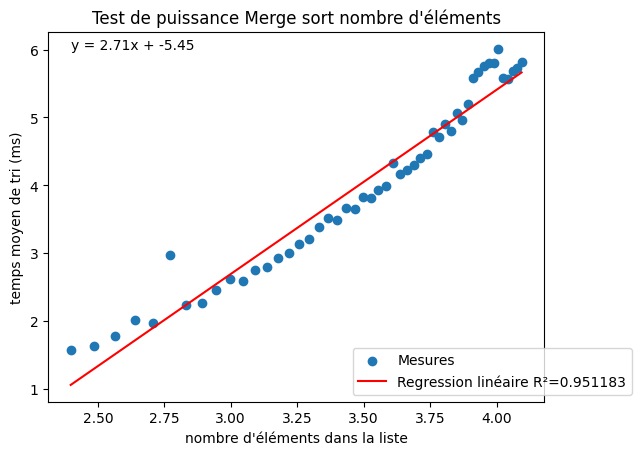

In [118]:
def dict_from_measures(measures: list[Measure]) -> dict:
    dict = {}
    for measure in measures:
        dict[np.log(measure.size)] = np.log(measure.mean)
    return dict

dict_greedy_sol = dict_from_measures(resultats_greedy)

test_de_puissance(dict_greedy_sol, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")

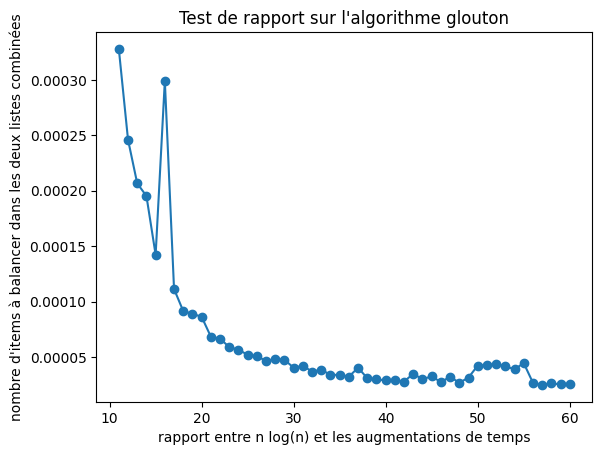

In [119]:
import math
def change_to_predict(measures: list[Measure], hypothesis = lambda x: x) -> dict:
    new_dict = {}
    for key in measures:
        new_dict[key.size] = key.mean/hypothesis(key.size)
    return new_dict

test_de_rapport(change_to_predict(resultats_greedy, lambda x: x**4), "rapport entre n log(n) et les augmentations de temps", "nombre d'items à balancer dans les deux listes combinées" , "Test de rapport sur l'algorithme glouton")

### Amélioration locale

In [120]:

def main_amelioration(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    updated = amelioration_locale(groups, target, n, sample, sol)
    sol = updated
    return sol

In [121]:
resultats_am_locale = measure_range(main_amelioration, problems)

display_data_as_table(resultats_am_locale)

initial solution


100%|██████████| 11/11 [00:00<00:00, 5602.59it/s]


--- 0.006039142608642578 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 13776.45it/s]


--- 0.0038192272186279297 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.004647970199584961 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.00683283805847168 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10990.32it/s]


--- 0.0070497989654541016 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 1464.26it/s]


--- 0.007512331008911133 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 6798.90it/s]


--- 0.0053386688232421875 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 1784.81it/s]


--- 0.006163120269775391 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<?, ?it/s]


--- 0.006114006042480469 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.0077915191650390625 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 24186.28it/s]


--- 0.0031092166900634766 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4108.37it/s]


--- 0.003425121307373047 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.002599000930786133 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 1590.86it/s]


--- 0.013712167739868164 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.006448507308959961 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4960.25it/s]


--- 0.0057849884033203125 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 3117.19it/s]


--- 0.004170417785644531 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<?, ?it/s]


--- 0.0010232925415039062 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 25744.08it/s]


--- 0.006303548812866211 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4565.90it/s]


--- 0.005664348602294922 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4397.25it/s]


--- 0.0076444149017333984 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 1617.69it/s]


--- 0.008036136627197266 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 2498.90it/s]


--- 0.005202293395996094 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 7188.66it/s]


--- 0.0036325454711914062 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2224.42it/s]


--- 0.006293773651123047 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 11266.36it/s]


--- 0.009183168411254883 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.0002796649932861328 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 1727.52it/s]


--- 0.008469820022583008 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2066.96it/s]


--- 0.006773233413696289 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2027.91it/s]


--- 0.006903648376464844 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6457.03it/s]


--- 0.0026717185974121094 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.004206418991088867 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 2991.96it/s]


--- 0.009164094924926758 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4833.63it/s]


--- 0.007525205612182617 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 9118.05it/s]


--- 0.009638786315917969 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.003226757049560547 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4099.47it/s]


--- 0.008069992065429688 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 2141.92it/s]


--- 0.007003068923950195 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<?, ?it/s]


--- 0.004069089889526367 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3561.13it/s]


--- 0.00664973258972168 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4426.55it/s]


--- 0.00796961784362793 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3634.79it/s]


--- 0.006866931915283203 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4982.54it/s]


--- 0.008085966110229492 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2346.30it/s]


--- 0.009775400161743164 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 6392.54it/s]


--- 0.009026765823364258 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 5066.73it/s]


--- 0.0071277618408203125 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3018.43it/s]


--- 0.013881921768188477 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2183.89it/s]


--- 0.007326364517211914 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2430.51it/s]


--- 0.012622594833374023 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2057.67it/s]


--- 0.007775783538818359 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3962.97it/s]


--- 0.014094829559326172 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.010648250579833984 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3242.29it/s]


--- 0.010516166687011719 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2849.96it/s]


--- 0.011754989624023438 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.013922691345214844 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 1132.53it/s]


--- 0.02013540267944336 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2392.00it/s]


--- 0.0071070194244384766 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 7478.83it/s]


--- 0.01328420639038086 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2590.58it/s]


--- 0.009941577911376953 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 5916.29it/s]


--- 0.007379770278930664 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 1693.06it/s]


--- 0.010040998458862305 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 1248.76it/s]


--- 0.013613462448120117 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3265.89it/s]


--- 0.02112603187561035 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 1356.72it/s]


--- 0.013267278671264648 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3957.10it/s]


--- 0.014262199401855469 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2037.06it/s]


--- 0.011168718338012695 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 7246.13it/s]


--- 0.006403684616088867 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3407.08it/s]


--- 0.0052831172943115234 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<?, ?it/s]


--- 0.0010907649993896484 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<?, ?it/s]


--- 0.013475656509399414 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3322.22it/s]


--- 0.011772871017456055 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3347.71it/s]


--- 0.013712406158447266 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2944.24it/s]


--- 0.015037298202514648 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1828.34it/s]


--- 0.010391950607299805 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 4211.59it/s]


--- 0.013687372207641602 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1362.65it/s]


--- 0.01394343376159668 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1573.38it/s]


--- 0.0129241943359375 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3169.54it/s]


--- 0.01380777359008789 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3494.18it/s]


--- 0.013835906982421875 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1366.69it/s]


--- 0.01390218734741211 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2422.46it/s]


--- 0.013852357864379883 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 1351.69it/s]


--- 0.01405644416809082 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1452.52it/s]


--- 0.013769149780273438 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 5013.81it/s]


--- 0.013863086700439453 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1429.65it/s]


--- 0.013989448547363281 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 932.08it/s]


--- 0.021457433700561523 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2145.48it/s]


--- 0.020998001098632812 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1546.23it/s]


--- 0.021125316619873047 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2650.18it/s]


--- 0.007546663284301758 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 5944.73it/s]


--- 0.011597394943237305 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1373.61it/s]


--- 0.014560222625732422 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 4236.67it/s]


--- 0.020348310470581055 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 9884.46it/s]


--- 0.015299797058105469 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 5740.75it/s]


--- 0.009700298309326172 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<?, ?it/s]


--- 0.0030519962310791016 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2967.97it/s]


--- 0.013332605361938477 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 7837.73it/s]


--- 0.015970706939697266 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2350.50it/s]

--- 0.014393806457519531 seconds for solution baseline ---
initial solution



100%|██████████| 21/21 [00:00<00:00, 2573.79it/s]


--- 0.015351295471191406 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2536.15it/s]


--- 0.008280277252197266 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<?, ?it/s]


--- 0.0056879520416259766 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 1900.29it/s]


--- 0.011050939559936523 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 6267.81it/s]

--- 0.007834434509277344 seconds for solution baseline ---
initial solution



100%|██████████| 22/22 [00:00<?, ?it/s]


--- 0.005985260009765625 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1342.80it/s]


--- 0.016383647918701172 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3872.37it/s]


--- 0.013952016830444336 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 13005.59it/s]


--- 0.014854192733764648 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 4883.29it/s]


--- 0.004505157470703125 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<?, ?it/s]


--- 0.0007357597351074219 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2695.49it/s]


--- 0.011745452880859375 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1463.91it/s]


--- 0.015028238296508789 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2703.80it/s]


--- 0.009116888046264648 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<?, ?it/s]

--- 0.0 seconds for solution baseline ---


initial solution


100%|██████████| 23/23 [00:00<00:00, 1653.03it/s]


--- 0.019762516021728516 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 10077.20it/s]


--- 0.015465259552001953 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<?, ?it/s]

--- 0.0043752193450927734 seconds for solution baseline ---
initial solution



100%|██████████| 23/23 [00:00<00:00, 1912.28it/s]


--- 0.019324064254760742 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 4070.59it/s]


--- 0.013948202133178711 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<?, ?it/s]


--- 0.015009403228759766 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<?, ?it/s]


--- 0.0 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<?, ?it/s]


--- 0.014780521392822266 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1599.20it/s]


--- 0.020891189575195312 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1201.52it/s]


--- 0.020725011825561523 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1559.12it/s]


--- 0.015393257141113281 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 3362.95it/s]


--- 0.011614322662353516 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 5284.72it/s]


--- 0.011114358901977539 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 4013.69it/s]


--- 0.020987510681152344 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 3164.02it/s]


--- 0.0179440975189209 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1599.45it/s]


--- 0.015005111694335938 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1586.95it/s]


--- 0.016754150390625 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1599.61it/s]


--- 0.017180442810058594 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1796.25it/s]

--- 0.018424034118652344 seconds for solution baseline ---
initial solution



100%|██████████| 25/25 [00:00<00:00, 2973.50it/s]

--- 0.021466970443725586 seconds for solution baseline ---
initial solution



100%|██████████| 25/25 [00:00<00:00, 1856.18it/s]


--- 0.013468503952026367 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1436.58it/s]


--- 0.019779205322265625 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 8538.20it/s]


--- 0.016030550003051758 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2271.17it/s]


--- 0.015017032623291016 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1805.87it/s]


--- 0.013843774795532227 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1173.05it/s]


--- 0.02131199836730957 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1275.69it/s]


--- 0.019597291946411133 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2745.54it/s]


--- 0.009105682373046875 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1284.97it/s]


--- 0.020819664001464844 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 848.63it/s]


--- 0.03251767158508301 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 3026.19it/s]


--- 0.016802072525024414 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1732.27it/s]


--- 0.015634775161743164 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1766.82it/s]


--- 0.01471567153930664 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1544.89it/s]


--- 0.016829729080200195 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1501.06it/s]


--- 0.023909568786621094 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1453.87it/s]


--- 0.024887561798095703 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1732.36it/s]


--- 0.01578354835510254 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 3824.10it/s]


--- 0.010306119918823242 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1652.70it/s]


--- 0.022098541259765625 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 5175.79it/s]


--- 0.01544952392578125 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1834.01it/s]


--- 0.020980119705200195 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1478.35it/s]


--- 0.03502249717712402 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1008.74it/s]


--- 0.03233909606933594 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2615.57it/s]


--- 0.02642226219177246 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1567.10it/s]


--- 0.02808833122253418 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1175.14it/s]


--- 0.023482799530029297 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2096.88it/s]


--- 0.012876272201538086 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1749.27it/s]


--- 0.03107285499572754 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1790.01it/s]

--- 0.015642404556274414 seconds for solution baseline ---
initial solution



100%|██████████| 28/28 [00:00<00:00, 1234.12it/s]


--- 0.02582693099975586 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1232.12it/s]


--- 0.02694869041442871 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1380.45it/s]

--- 0.02943587303161621 seconds for solution baseline ---
initial solution



100%|██████████| 28/28 [00:00<00:00, 1503.84it/s]


--- 0.024100065231323242 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1450.98it/s]


--- 0.02730083465576172 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 950.54it/s]


--- 0.03591012954711914 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 832.79it/s]


--- 0.04045987129211426 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1175.18it/s]


--- 0.03323554992675781 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1441.32it/s]

--- 0.025435209274291992 seconds for solution baseline ---
initial solution



100%|██████████| 29/29 [00:00<00:00, 1259.79it/s]


--- 0.030567646026611328 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1269.26it/s]


--- 0.02770209312438965 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1245.61it/s]


--- 0.02883458137512207 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1302.97it/s]


--- 0.02785205841064453 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1252.06it/s]


--- 0.029046297073364258 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1364.03it/s]


--- 0.028916358947753906 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1231.88it/s]


--- 0.029429912567138672 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1375.83it/s]


--- 0.027292251586914062 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1260.91it/s]


--- 0.0287930965423584 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1321.46it/s]


--- 0.0264589786529541 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1185.31it/s]


--- 0.03186798095703125 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1138.51it/s]


--- 0.032370567321777344 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1163.53it/s]


--- 0.03295326232910156 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1306.09it/s]


--- 0.02998185157775879 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1235.62it/s]


--- 0.03033757209777832 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1201.71it/s]


--- 0.19586658477783203 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1083.66it/s]


--- 0.03368639945983887 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1162.68it/s]


--- 0.031322479248046875 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1207.49it/s]


--- 0.03007197380065918 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1220.95it/s]

--- 0.032486677169799805 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 1026.10it/s]

--- 0.03621673583984375 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 1076.16it/s]


--- 0.03469491004943848 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1152.66it/s]


--- 0.03466439247131348 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1052.64it/s]


--- 0.03661990165710449 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1017.41it/s]

--- 0.03852558135986328 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 1025.13it/s]


--- 0.03615140914916992 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1073.93it/s]


--- 0.035867929458618164 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1097.85it/s]


--- 0.03511404991149902 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1183.72it/s]


--- 0.035187721252441406 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1159.85it/s]


--- 0.03314685821533203 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 997.61it/s]


--- 0.03772330284118652 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 876.76it/s]


--- 0.04209280014038086 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 970.79it/s]


--- 0.041695356369018555 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1050.09it/s]


--- 0.038483619689941406 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1046.59it/s]


--- 0.0355832576751709 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 952.13it/s]


--- 0.03937411308288574 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1035.90it/s]


--- 0.03566288948059082 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1075.32it/s]

--- 0.037773847579956055 seconds for solution baseline ---


initial solution


100%|██████████| 32/32 [00:00<00:00, 908.11it/s]


--- 0.04223465919494629 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 980.62it/s]


--- 0.03764057159423828 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 791.24it/s]


--- 0.04873180389404297 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 952.04it/s]


--- 0.04238724708557129 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 1007.75it/s]


--- 0.03869175910949707 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 803.88it/s]


--- 0.04723787307739258 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 972.70it/s]


--- 0.039931297302246094 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 956.36it/s]


--- 0.043027639389038086 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 886.46it/s]


--- 0.04534745216369629 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 951.16it/s]


--- 0.040204763412475586 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 962.74it/s]


--- 0.041543006896972656 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 791.89it/s]


--- 0.04767251014709473 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 818.38it/s]


--- 0.04789137840270996 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 931.52it/s]


--- 0.04308772087097168 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 924.17it/s]


--- 0.045797109603881836 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 946.10it/s]


--- 0.04193878173828125 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 780.06it/s]


--- 0.0531463623046875 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 835.33it/s]


--- 0.04670238494873047 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 929.58it/s]

--- 0.04420304298400879 seconds for solution baseline ---
initial solution



100%|██████████| 34/34 [00:00<00:00, 804.46it/s]


--- 0.04627108573913574 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 896.03it/s]


--- 0.04594922065734863 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 743.05it/s]


--- 0.053244590759277344 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 764.82it/s]


--- 0.05368375778198242 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 787.85it/s]


--- 0.05183076858520508 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 870.82it/s]


--- 0.048827409744262695 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 793.61it/s]


--- 0.05281972885131836 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 870.93it/s]


--- 0.049192190170288086 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 760.37it/s]


--- 0.05303525924682617 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 822.04it/s]


--- 0.05058169364929199 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 732.70it/s]

--- 0.05499696731567383 seconds for solution baseline ---


initial solution


100%|██████████| 35/35 [00:00<00:00, 726.63it/s]


--- 0.05537581443786621 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 813.27it/s]


--- 0.04931020736694336 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 700.10it/s]


--- 0.05962324142456055 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 751.63it/s]


--- 0.05446982383728027 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 811.79it/s]


--- 0.051248788833618164 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 549.99it/s]


--- 0.07678675651550293 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 771.45it/s]


--- 0.05404353141784668 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 815.94it/s]


--- 0.051372528076171875 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 790.65it/s]


--- 0.05254507064819336 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 794.43it/s]


--- 0.05183744430541992 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 767.06it/s]


--- 0.052411794662475586 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 835.50it/s]


--- 0.05164027214050293 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 722.42it/s]


--- 0.060221195220947266 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 672.25it/s]


--- 0.06353616714477539 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 737.06it/s]


--- 0.057089805603027344 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 542.15it/s]


--- 0.07779240608215332 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 736.99it/s]


--- 0.057579994201660156 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 729.77it/s]


--- 0.058664798736572266 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 692.35it/s]


--- 0.06143808364868164 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 693.52it/s]


--- 0.06004190444946289 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 690.24it/s]


--- 0.062219858169555664 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 769.49it/s]


--- 0.05653953552246094 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 653.68it/s]


--- 0.06715035438537598 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 706.76it/s]


--- 0.06176638603210449 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 676.89it/s]


--- 0.06587791442871094 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 685.77it/s]


--- 0.06401824951171875 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 634.95it/s]


--- 0.06649589538574219 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 656.23it/s]


--- 0.06848692893981934 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 665.33it/s]


--- 0.06625652313232422 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 571.12it/s]


--- 0.07756972312927246 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 729.17it/s]


--- 0.06111598014831543 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 680.45it/s]


--- 0.06609296798706055 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 604.00it/s]


--- 0.07288837432861328 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 628.15it/s]


--- 0.07009315490722656 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 514.23it/s]


--- 0.08461809158325195 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 606.91it/s]


--- 0.07282662391662598 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 652.71it/s]


--- 0.06855368614196777 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 616.71it/s]


--- 0.07116532325744629 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 632.66it/s]


--- 0.06964421272277832 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 693.59it/s]


--- 0.06391191482543945 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 649.20it/s]


--- 0.06663370132446289 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 675.90it/s]


--- 0.06979131698608398 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 579.84it/s]


--- 0.23128104209899902 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 645.45it/s]

--- 0.06990528106689453 seconds for solution baseline ---
initial solution



100%|██████████| 40/40 [00:00<00:00, 556.38it/s]


--- 0.08102536201477051 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 573.21it/s]


--- 0.07811164855957031 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 634.37it/s]


--- 0.07206058502197266 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 644.33it/s]


--- 0.0712122917175293 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 600.18it/s]


--- 0.07416462898254395 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 495.00it/s]


--- 0.0910027027130127 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 575.51it/s]


--- 0.07664775848388672 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 611.97it/s]


--- 0.07350492477416992 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 546.35it/s]


--- 0.08556747436523438 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 592.54it/s]


--- 0.07727646827697754 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 553.73it/s]


--- 0.0830540657043457 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 526.64it/s]


--- 0.08693861961364746 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 529.46it/s]


--- 0.08602309226989746 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 592.01it/s]


--- 0.07836127281188965 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 557.92it/s]


--- 0.08290863037109375 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 543.28it/s]


--- 0.08397364616394043 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 601.71it/s]


--- 0.07717537879943848 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 569.58it/s]


--- 0.0805823802947998 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 522.35it/s]


--- 0.08966875076293945 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 580.81it/s]


--- 0.08084297180175781 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 526.92it/s]


--- 0.08905386924743652 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 536.49it/s]


--- 0.08679485321044922 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 536.41it/s]


--- 0.0852961540222168 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 542.32it/s]


--- 0.08891749382019043 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 496.01it/s]


--- 0.09104061126708984 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 571.44it/s]


--- 0.08289551734924316 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 505.23it/s]


--- 0.09077692031860352 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 563.78it/s]


--- 0.08376526832580566 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 489.26it/s]


--- 0.09788775444030762 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 524.61it/s]


--- 0.08972692489624023 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 508.72it/s]


--- 0.09569692611694336 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 541.83it/s]


--- 0.08870267868041992 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 510.48it/s]


--- 0.09331369400024414 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 492.63it/s]


--- 0.09690213203430176 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 493.98it/s]

--- 0.09619808197021484 seconds for solution baseline ---


initial solution


100%|██████████| 43/43 [00:00<00:00, 484.90it/s]


--- 0.10168814659118652 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 475.15it/s]


--- 0.10006594657897949 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 516.24it/s]


--- 0.09146428108215332 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 492.14it/s]


--- 0.09884858131408691 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 508.19it/s]


--- 0.09639167785644531 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 486.09it/s]


--- 0.09853434562683105 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 452.66it/s]


--- 0.10823488235473633 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 484.40it/s]


--- 0.09987306594848633 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 473.44it/s]


--- 0.24554443359375 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 442.11it/s]


--- 0.10854840278625488 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 510.47it/s]


--- 0.09636831283569336 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 462.17it/s]


--- 0.10332965850830078 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 478.67it/s]


--- 0.09998130798339844 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 463.67it/s]


--- 0.1071932315826416 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 445.43it/s]


--- 0.1113896369934082 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 457.59it/s]


--- 0.10742425918579102 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 452.50it/s]


--- 0.10802888870239258 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 459.00it/s]


--- 0.10818362236022949 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 489.10it/s]


--- 0.10201215744018555 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 339.78it/s]

--- 0.14344048500061035 seconds for solution baseline ---


initial solution


100%|██████████| 45/45 [00:00<00:00, 453.12it/s]


--- 0.10827112197875977 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 508.46it/s]


--- 0.09761667251586914 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 422.43it/s]


--- 0.11452674865722656 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 314.77it/s]


--- 0.15525317192077637 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 399.68it/s]


--- 0.12396764755249023 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 424.22it/s]


--- 0.11896038055419922 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 425.69it/s]


--- 0.11791133880615234 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 427.27it/s]


--- 0.11866641044616699 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 353.20it/s]


--- 0.13823843002319336 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 418.02it/s]


--- 0.11877655982971191 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 394.29it/s]


--- 0.1273646354675293 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 397.45it/s]


--- 0.12580633163452148 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 431.09it/s]


--- 0.11475872993469238 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 391.64it/s]


--- 0.1301562786102295 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 409.33it/s]


--- 0.12383127212524414 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 394.41it/s]


--- 0.1302952766418457 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 400.69it/s]


--- 0.12735724449157715 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 391.18it/s]


--- 0.1313333511352539 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 416.03it/s]


--- 0.12316679954528809 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 411.72it/s]


--- 0.12241530418395996 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 396.30it/s]


--- 0.13054394721984863 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 411.31it/s]


--- 0.1227266788482666 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 381.02it/s]


--- 0.27884817123413086 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 370.18it/s]


--- 0.1396772861480713 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 362.06it/s]


--- 0.1425330638885498 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 399.41it/s]


--- 0.13033723831176758 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 358.50it/s]


--- 0.1456458568572998 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 423.54it/s]


--- 0.12454032897949219 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 375.40it/s]


--- 0.13614726066589355 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 369.33it/s]


--- 0.14025235176086426 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 375.35it/s]


--- 0.13740062713623047 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 352.09it/s]


--- 0.1466224193572998 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 333.08it/s]

--- 0.1541600227355957 seconds for solution baseline ---


initial solution


100%|██████████| 49/49 [00:00<00:00, 353.60it/s]

--- 0.14916706085205078 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 313.80it/s]

--- 0.16822361946105957 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 341.77it/s]


--- 0.15495657920837402 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 346.65it/s]

--- 0.15179133415222168 seconds for solution baseline ---


initial solution


100%|██████████| 49/49 [00:00<00:00, 347.90it/s]


--- 0.15085792541503906 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 379.81it/s]


--- 0.13941097259521484 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 370.03it/s]


--- 0.1425318717956543 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 365.53it/s]


--- 0.14458274841308594 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 345.79it/s]

--- 0.1533679962158203 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 361.63it/s]


--- 0.1454629898071289 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 318.52it/s]


--- 0.16811203956604004 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 317.66it/s]


--- 0.17073917388916016 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 351.46it/s]


--- 0.15276479721069336 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 346.28it/s]

--- 0.15453529357910156 seconds for solution baseline ---
initial solution



100%|██████████| 50/50 [00:00<00:00, 322.69it/s]

--- 0.16560578346252441 seconds for solution baseline ---


initial solution


100%|██████████| 50/50 [00:00<00:00, 347.45it/s]

--- 0.3135683536529541 seconds for solution baseline ---


initial solution


100%|██████████| 50/50 [00:00<00:00, 338.51it/s]


--- 0.157928466796875 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 360.86it/s]


--- 0.1487739086151123 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 329.15it/s]

--- 0.16399383544921875 seconds for solution baseline ---
initial solution



100%|██████████| 50/50 [00:00<00:00, 333.24it/s]


--- 0.16137146949768066 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 305.07it/s]


--- 0.17817974090576172 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 316.47it/s]


--- 0.17334532737731934 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 337.31it/s]


--- 0.16382646560668945 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 314.84it/s]

--- 0.171522855758667 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 324.98it/s]


--- 0.16909289360046387 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 325.17it/s]


--- 0.16884183883666992 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 339.43it/s]

--- 0.1615738868713379 seconds for solution baseline ---
initial solution



100%|██████████| 51/51 [00:00<00:00, 317.75it/s]


--- 0.171128511428833 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 305.00it/s]

--- 0.179793119430542 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 281.04it/s]


--- 0.19047236442565918 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 284.74it/s]


--- 0.1943669319152832 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 276.05it/s]


--- 0.20087456703186035 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 297.40it/s]


--- 0.18585848808288574 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 273.07it/s]


--- 0.20300745964050293 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 285.30it/s]


--- 0.33657169342041016 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 295.81it/s]


--- 0.1857914924621582 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 322.59it/s]


--- 0.17221474647521973 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 298.93it/s]


--- 0.18608403205871582 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 320.25it/s]


--- 0.17486023902893066 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 303.84it/s]


--- 0.18114924430847168 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 285.93it/s]


--- 0.19751811027526855 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 290.82it/s]


--- 0.19288253784179688 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 308.35it/s]


--- 0.18365740776062012 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 280.44it/s]


--- 0.2002394199371338 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 302.73it/s]


--- 0.18802452087402344 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 286.51it/s]


--- 0.19718694686889648 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 289.85it/s]


--- 0.19406938552856445 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 269.08it/s]


--- 0.206650972366333 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 289.54it/s]


--- 0.19504976272583008 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 297.65it/s]


--- 0.1895735263824463 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 282.07it/s]


--- 0.20455670356750488 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 283.28it/s]


--- 0.19984865188598633 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 280.64it/s]


--- 0.3562805652618408 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 262.23it/s]


--- 0.21764659881591797 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 277.79it/s]


--- 0.20755863189697266 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 275.36it/s]


--- 0.2077646255493164 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 223.99it/s]


--- 0.25222039222717285 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 276.96it/s]


--- 0.2071080207824707 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 261.02it/s]


--- 0.2188880443572998 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 256.61it/s]


--- 0.22156929969787598 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 260.00it/s]


--- 0.22369694709777832 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 248.06it/s]


--- 0.23384881019592285 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 278.22it/s]


--- 0.21038126945495605 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 245.76it/s]


--- 0.2347266674041748 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 281.12it/s]


--- 0.20663237571716309 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 250.58it/s]


--- 0.2297077178955078 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 277.61it/s]

--- 0.2119734287261963 seconds for solution baseline ---


initial solution


100%|██████████| 55/55 [00:00<00:00, 252.35it/s]


--- 0.3690948486328125 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 251.61it/s]


--- 0.231201171875 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 271.44it/s]


--- 0.2147376537322998 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 249.98it/s]


--- 0.24059748649597168 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 226.39it/s]


--- 0.2593648433685303 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 243.43it/s]


--- 0.2456507682800293 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 229.60it/s]


--- 0.259354829788208 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 236.20it/s]


--- 0.25066184997558594 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 261.63it/s]


--- 0.22556090354919434 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 240.06it/s]


--- 0.24644088745117188 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 260.28it/s]


--- 0.22651124000549316 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 248.06it/s]


--- 0.23764896392822266 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 248.69it/s]


--- 0.24043488502502441 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 240.63it/s]


--- 0.24924349784851074 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 246.74it/s]


--- 0.3913235664367676 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 218.30it/s]


--- 0.2750236988067627 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 223.11it/s]


--- 0.26759886741638184 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 214.31it/s]


--- 0.2794632911682129 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 215.02it/s]


--- 0.2802584171295166 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 211.75it/s]


--- 0.28197383880615234 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 210.18it/s]


--- 0.28532862663269043 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 218.18it/s]


--- 0.27335190773010254 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 226.61it/s]


--- 0.26439976692199707 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 218.87it/s]


--- 0.2775120735168457 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 218.13it/s]


--- 0.27724361419677734 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 224.82it/s]


--- 0.2712574005126953 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 220.58it/s]


--- 0.42720723152160645 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 218.94it/s]


--- 0.2796666622161865 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 220.28it/s]


--- 0.27774906158447266 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 203.04it/s]


--- 0.29966115951538086 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 204.71it/s]


--- 0.29633212089538574 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 206.21it/s]


--- 0.29581618309020996 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 211.07it/s]


--- 0.2869250774383545 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 217.26it/s]


--- 0.28537654876708984 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 212.75it/s]


--- 0.29187607765197754 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 201.32it/s]


--- 0.30656957626342773 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 197.99it/s]


--- 0.31134605407714844 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 207.73it/s]


--- 0.45722174644470215 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 217.95it/s]


--- 0.28443479537963867 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 211.23it/s]


--- 0.2929530143737793 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 204.09it/s]


--- 0.301133394241333 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 200.94it/s]


--- 0.30899930000305176 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 220.49it/s]


--- 0.2806830406188965 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 200.46it/s]


--- 0.31372928619384766 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 194.87it/s]


--- 0.3216421604156494 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 193.72it/s]


--- 0.326458215713501 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 202.41it/s]


--- 0.31145191192626953 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 210.57it/s]


--- 0.2980008125305176 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 194.14it/s]


--- 0.4941709041595459 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 199.41it/s]


--- 0.31580233573913574 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 198.95it/s]


--- 0.31639742851257324 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 205.66it/s]


--- 0.30603957176208496 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 194.61it/s]

--- 0.32344675064086914 seconds for solution baseline ---
Taille       Temps moyen  Score moyen 
11           5.4          340.23636363636365
12           4.8          509.8166666666666
13           5.8          537.8076923076923
14           6.3          686.1142857142856
15           7.3          894.4133333333333
16           10.6         1115.475    
17           11.4         1342.4882352941177
18           11.1         1611.3277777777778
19           13.6         1799.1473684210528
20           17.1         2384.2      
21           11.9         2712.1428571428573
22           14.2         3070.3045454545454
23           13.5         3013.6478260869562
24           17.4         3510.1583333333338
25           19.0         3829.8      
26           20.7         4407.0615384615385
27           26.4         4402.644444444444
28           29.6         5277.7357142857145
29           30.1         4880.420689655172
30           49.6         5914.496666666667
31           37.6         62

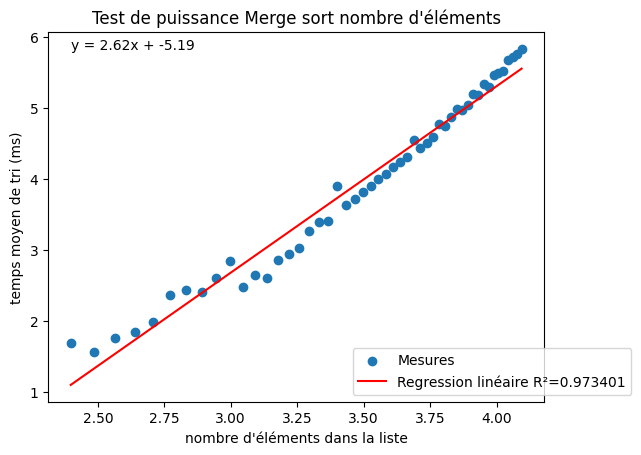

In [122]:
dict_am_locale = dict_from_measures(resultats_am_locale)

test_de_puissance(dict_am_locale, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")

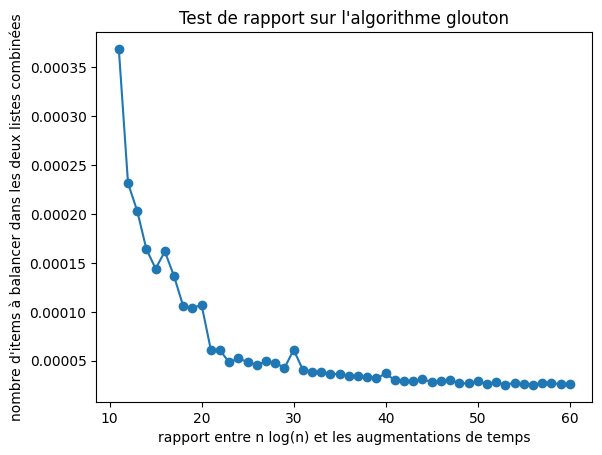

In [123]:
test_de_rapport(change_to_predict(resultats_am_locale, lambda x: x**4), "rapport entre n log(n) et les augmentations de temps", "nombre d'items à balancer dans les deux listes combinées" , "Test de rapport sur l'algorithme glouton")

### Amélioration locale

Ceci était un essaie qui ne fonctionne pas de calculer indépendamment l'amélioration locale

In [124]:
def main_preparation(sample):
    start_time = time.time()
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    sol, groups = max_to_target(counties, target, n)
    return (sol, groups, sample, n, target, counties)
    

In [125]:
problems = make_problems([x for x in range(11, 15)], 10)
resultats_initials = {"solutions_initiales": [],
                       "groupes": [],
                       "samples": [],
                       "ns": [],
                       "targets": [], 
                       "counties": []}
for prob in problems:
    solutions_initiales, groupes, samples, ns, targets, counties = [], [], [], [], [], []
    sols = [main_preparation(sample) for sample in prob.generate_dataset()]
    for sol in sols:
        solutions_initiales.append(sol[0])
        groupes.append(sol[1])
        samples.append(sol[2])
        ns.append(sol[3])
        targets.append(sol[4])
        counties.append(sol[5])
    
    resultats_initials["solutions_initiales"].append(solutions_initiales)
    resultats_initials["groupes"].append(groupes)
    resultats_initials["samples"].append(samples)
    resultats_initials["ns"].append(ns)
    resultats_initials["targets"].append(targets)
    resultats_initials["counties"].append(counties)



100%|██████████| 14/14 [00:00<00:00, 4455.93it/s]


In [126]:

def main_amelioration(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = resultats_initials["counties"]
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    print('improvement')
    while(True):
        updated = amelioration_locale(groups, target, n, sample, sol)
        sol = updated

In [96]:
print(resultats_initials["groupes"])

resultats_am_locale = measure(lambda x: amelioration_locale(x["groupes"][0][0], x["targets"][0][0], x["ns"][0][0], x["samples"][0][0], x["solutions_initiales"][0][0]), resultats_initials)

display_data_as_table(resultats_graphs)

[[[[<__main__.County object at 0x00000190972F8D10>, <__main__.County object at 0x00000190972F9430>, <__main__.County object at 0x00000190972F8FB0>, <__main__.County object at 0x00000190972FBE30>, <__main__.County object at 0x00000190972FB200>, <__main__.County object at 0x00000190972FA540>, <__main__.County object at 0x00000190972F86E0>, <__main__.County object at 0x00000190972FA480>, <__main__.County object at 0x00000190972FA840>, <__main__.County object at 0x00000190972FB290>, <__main__.County object at 0x00000190972FB3E0>], [<__main__.County object at 0x00000190972F8830>, <__main__.County object at 0x00000190972F89B0>, <__main__.County object at 0x00000190972FAA20>, <__main__.County object at 0x00000190972FB710>, <__main__.County object at 0x00000190972F9B20>, <__main__.County object at 0x00000190972FA4B0>, <__main__.County object at 0x00000190972FA150>, <__main__.County object at 0x00000190972FB500>, <__main__.County object at 0x00000190972F8650>, <__main__.County object at 0x00000

InvalidSolution: Invalid solution, verify your code.

# Analyse code carbon (2 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.

In [ ]:
from codecarbon import EmissionsTracker
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("main")
    # TODO Appel glouton
    results = measure_range(main, make_problems([x for x in range(11, 61)], [5]))
    tracker.stop_task()

finally:
    _ = tracker.stop()

# Conclusion (6 pts)

# Étapes d'amélioration pour arriver à notre version actuelle
Nous avons commencé par un algorithme glouton qui n'avait aucune gestion du temps et aucune amélioration après le passage initial. Cet algorithme était en theta(n³) au lieu de theta(n⁴) comme notre algorithme actuel, car nous faisions une selection  du premier élément d'un groupe de manière complètment aléatoire. De plus, lorsqu'il n'y avait pas de voisins disponibles pour choisir le prochain élément, l'élément choisi dans le groupe était aléatoire ce qui donnait de mauvais scores de distance. De plus, nous n'avions pas encore l'objet County pour nous aider à clarifier le code. Du fait, nos heuristiques de choix de prochain élément étaient très rudimentaires et inefficace. Les score pour n=100 étaient autour de 700 000.

Nous avons par la suite ajouté une section d'amélioration locale. Pour choisir le groupe auquel nous voulions faire une amélioration, nous avons commencé par prendre celui qui a un nombre de vote le plus près d'une majorité et prendre le meilleur des échanges. Par contre, nous avons réalisé que certains des échanges étaient considérés comme sous optimaux et pris quand même. De plus, seulement un groupe recevait des modifications constantes jusqu'à atteindre un nombre de vote majoritaire puis un prochain. Nous avons donc changé notre algorithme pour prendre un groupe aléatoire parmis tous et vérifier que le meilleur échange améliore la situation et sinon ne pas faire d'échange. Ceci nous a permis de ne pas rester pris dans un minimum et presque toujours faire des améliorations avec chaque passage et arrêter seuelement lorsque le score obtenu est excellent.

# Points forts de notre algorithme
Notre algorithme trouve une solution initiale qui est souvent vraiment bonne et satisfaisante, même sans la mise en place d'une amélioration locale. Bref, bien que la complexité soit grande, notre passage initial donne une solution d'environ 25 000 pour n=100.

L'autre force de notre algorithme est que l'amélioration locale améliore rellement le score même après une grande quantité d'améliorations. En effet, le groupe qui reçoit une amélioration est choisi aléatoirement ce qui nous permet de tout améliorer. De plus, si jamais la quantité d'amélioration maximale pour la solution actuelle est atteinte, notre algorithme va préférer ne prendre aucune action plutôt qu'une action sous optimale.

# Points faibles de notre algorithme
Notre algorithme est vraiment lent pour trouver une solution initiale. Bien que la solution soit bonne, elle demande un trop grand temps de calcul pour de grandes valeurs de n. Un autre point faible de notre algorithme est de ne pas prendre avantage du débalancement possible dans les grandeurs des groupes de County. Nous pourrions surement aller chercher des scores plus élevés avec un débalancement faible dans le nombre de County inclus par groupe.

# Amélioration possibles
Pour améliorer notre algorithme, 2 avenues sont à explorer. La première est de fournir une version encore plus rapide de solution initiale pour être correct dans des situations ou le n prend une très très grande valeur. Ainsi je crois qu'il faudrait un système de thread pour faire des interruptions pour s'assurer de ne pas dépasser les temps prévus peu import la technique utilisée. Bien sur, l'utilisation de thread serait aussi très utile pour accélérer les performances et non seulement faire un meilleur timer.

La deuxième amélioration que nous aurions aimé explorer avec plus de temps est d'introduire un débalancement dans le nombre de County par groupe de vote. Ainsi, nous aurions pu réduire le score de groupes gagnés qui devient important avec des grandes valeurs par sa nature quadratique. Pour faire ce débalancement, l'algorithme d'amélioration locale pourrait avoir la capacité de prendre un County au lieu de simplement faire des échanges.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.